# The Study

The objective of this study is to observe data for video game sales and reviews and identify patterns for games to succeed. We can then use these patterns to plan advertising campaigns for an online video game store.

In [3]:
#Let's initialize our notebook with important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import sys
import warnings

In [4]:
#Supress memory usage warnings.
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## The Data

In [5]:
#Let's load the data and write some initial observations by inspecting it. 
try:
    games = pd.read_csv('/datasets/games.csv')
except:
    print('Error, please check filepath')

In [6]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


The data contains the following columns: 
1. `Name` - The title of the game
2. `Platform` - The platform for which the game was released
3. `Year of Release`
4. `Genre` - Genre of the game
5. `NA_sales` - North America Sales(in millions)
6. `EU_sales` - EU Sales (in millions)
7. `JP_sales` - Japan Sales(in millions)
8. `Other_sales` - Sales in other countries(in millions)
9. `Critic_Score` - A score out of 100
10. `User_Score` - A score out of 10
11. `Rating` - ESRB Rating

In [7]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Initital Observations**:
1. The column names are inconsistently formatted.
2. Some missing values exist for `name`, `year_of_release`, `critic_score`, `user_score` and `rating`.  
3. `user_score` is object type. It should be float type but with some values set to tbd, we cannot yet change it.
4. We will keep `year_of_release` as float64 for now as we may not need to use datetime properties.

## Fixing the Data

### Column Names

In [8]:
#Let's fix the column headers
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Converting Data Types

Let's take a closer look at the `user_score` column

In [9]:
games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.6       2
0.2       2
1.9       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

In [10]:
games.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


In [11]:
games['user_score'].isna().sum()

6701

The values mentioned as tbd are simply missing values as we have no way to determine the `user_score`. Let's replace tbd with NaN values. We will later attempt to fill in as many values as possible. 

In [12]:
games['user_score'] = games['user_score'].replace(to_replace = 'tbd', value = np.nan)
games['user_score'].isna().sum()

9125

We will fill in missing values next.

### Dealing with Missing Values

In [13]:
games[games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Let's drop the two values as they constitute a very small percentage and we have no way to find out a name from other data. 

In [14]:
games = games[~games['name'].isna()]

In [15]:
games['name'].isna().sum()

0

In [16]:
games['genre'].isna().sum()

0

In [17]:
missing_year_pct = games['year_of_release'].isna().sum() / games.shape[0] * 100
print(f'Missing values for year_of_release: {missing_year_pct:.2f}%')

Missing values for year_of_release: 1.61%


We can safely drop these values but let's take a closer look first.

In [18]:
games.query('year_of_release.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


We notice that in some cases, the name of the game ends with a year. We cna utilise this but it will only fill a small percentage of values. It's not worth the effort to save ~0.5% of values. We will simply drop these rows.

In [19]:
games = games.query('~year_of_release.isna()')

In [20]:
#Let's recap
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null object
rating             9768 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


We need to fill missing values for `critic_score` and `user_score` where possible. Let's try to find out if the NaN values occur simultaneously for both columns 

In [21]:
games.query('user_score.isna() and critic_score.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In over 7892 cases, the values are missing simultaneously, which means we cannot fill in the values simply by looking at others in all cases. We will still try to find the correlation between the two and fill in as many values as possible.

In [22]:
games['user_score'] = games['user_score'].astype('float')

In [23]:
games['user_score'].dtype

dtype('float64')

In [24]:
games.corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
year_of_release,1.000000,-0.092326,0.004045,-0.168477,0.037821,0.011411,-0.267851
na_sales,-0.092326,1.000000,0.766546,0.451162,0.638479,0.240083,0.085549
eu_sales,0.004045,0.766546,1.000000,0.435894,0.722679,0.221276,0.055530
jp_sales,-0.168477,0.451162,0.435894,1.000000,0.291562,0.153474,0.126372
other_sales,0.037821,0.638479,0.722679,0.291562,1.000000,0.198410,0.056935
critic_score,0.011411,0.240083,0.221276,0.153474,0.198410,1.000000,0.579671
user_score,-0.267851,0.085549,0.055530,0.126372,0.056935,0.579671,1.000000


Clearly, a sufficiently strong correlation exists between `critic_score` and `user_score`. We can fill nan values from one column to the other as much as possible

In [25]:
games.groupby('name')['critic_score'].transform('first') / 10

0        7.6
1        NaN
2        8.2
3        8.0
4        NaN
        ... 
16710    NaN
16711    NaN
16712    NaN
16713    NaN
16714    NaN
Name: critic_score, Length: 16444, dtype: float64

In [26]:
games['user_score'] = games['user_score'].fillna(games.groupby('name')['critic_score'].transform('first') / 10)

In [27]:
games['critic_score'] = games['critic_score'].fillna(games.groupby('name')['user_score'].transform('first') * 10)

In [28]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       9257 non-null float64
user_score         9158 non-null float64
rating             9768 non-null object
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


We managed to fill NaN values in both `critic_score` and `user_score` columns. We cannot fill the rest without using external data sources, so we will ignore them for now. Let's look at the rating column

In [29]:
games['rating']

0          E
1        NaN
2          E
3          E
4        NaN
        ... 
16710    NaN
16711    NaN
16712    NaN
16713    NaN
16714    NaN
Name: rating, Length: 16444, dtype: object

It is safe to assume that ratings for games do not vary across platforms. We will simply fill in all values we can by looking at the names. 

In [30]:
games['rating'] = games['rating'].fillna(games.groupby('name')['rating'].transform('first'))

In [31]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       9257 non-null float64
user_score         9158 non-null float64
rating             10185 non-null object
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


We have successfully filled as many non-null values as we could. Let's move to the next steps

### Total Sales

Let's calculate total sales for each game. 

In [32]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']       

In [33]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


## Analysis

### Platform Longevity and Sales Patterns

In [34]:
games_by_platform = games.pivot_table(index=['platform','year_of_release'], values='total_sales', aggfunc = 'sum')

As gaming is a fast evolving industry, it is expected that platforms will be replaced by newer, more advanced ones. As this happens, older platforms will see fewer games released for them. Let's find the trend for a platform to die out.

In [35]:
games_by_platform

total_sales
platform year_of_release             
2600     1980.0                 11.38
         1981.0                 35.68
         1982.0                 28.88
         1983.0                  5.84
         1984.0                  0.27
...                               ...
XB       2008.0                  0.18
XOne     2013.0                 18.96
         2014.0                 54.07
         2015.0                 60.14
         2016.0                 26.15

[238 rows x 1 columns]

In [36]:
games['platform'].nunique()

31

In [37]:
def plot_platform(platform):
    games_by_platform.loc[platform].plot(kind = 'bar', figsize = (6,6))
    plt.title(f'Game Release Pattern of {platform}.')
    plt.xlabel('Year')
    plt.ylabel('Total Sales in USD Millions')

In [38]:
platforms = games['platform'].unique()
platforms

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

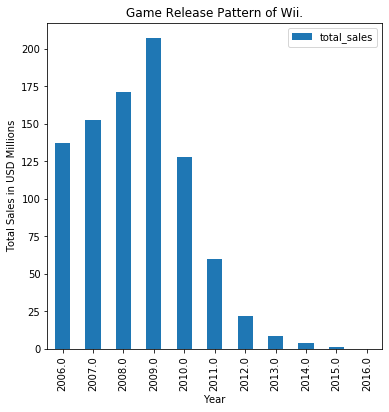

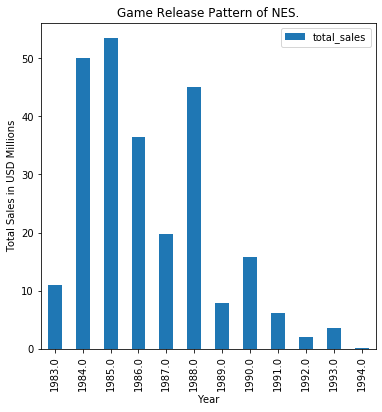

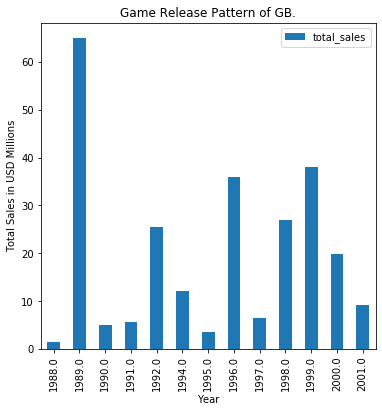

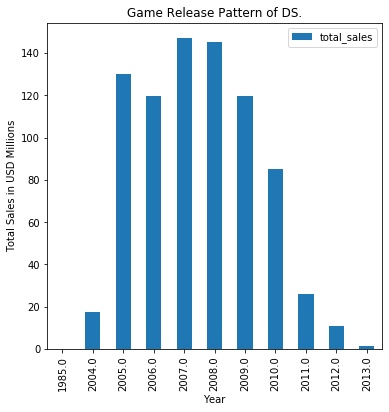

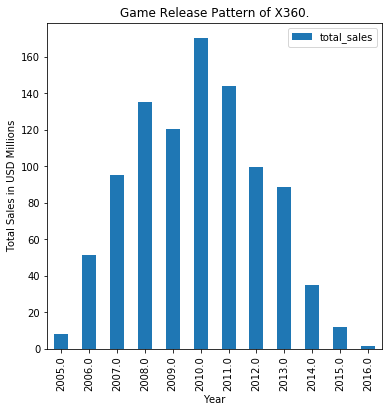

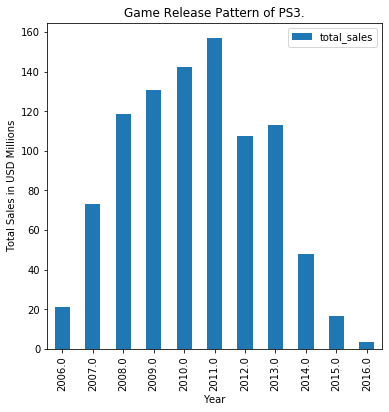

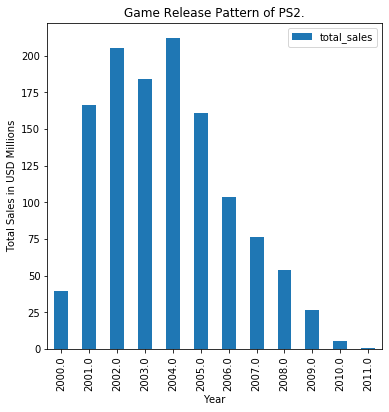

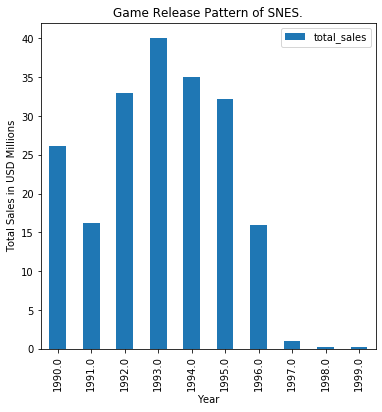

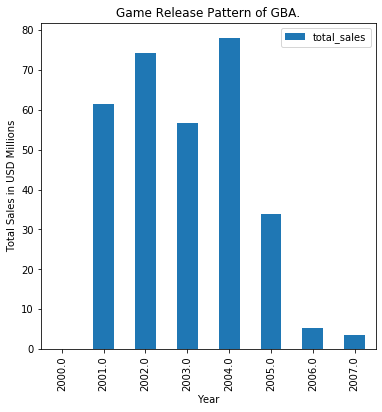

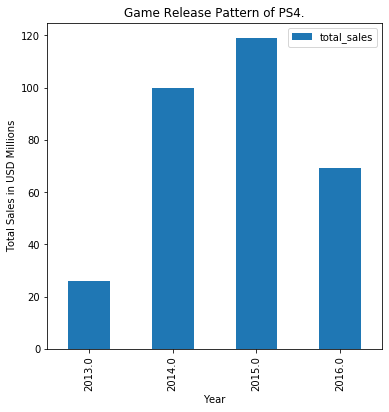

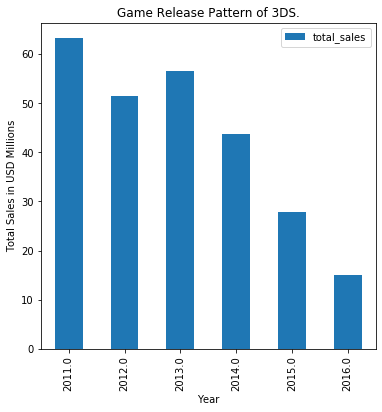

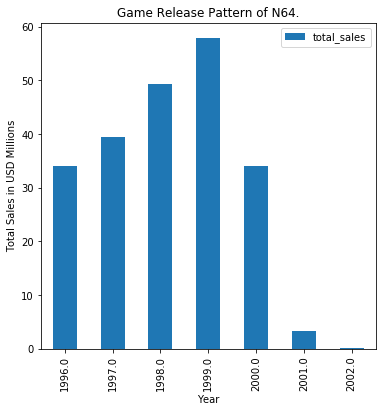

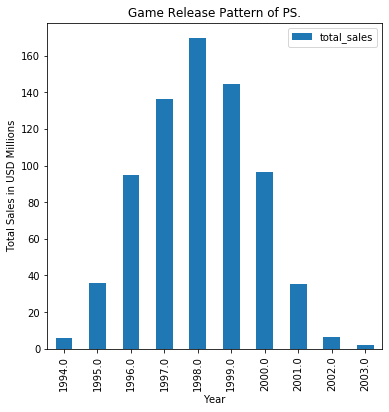

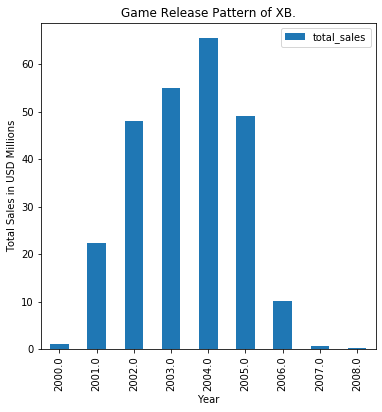

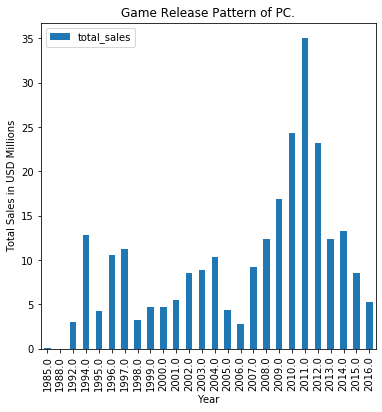

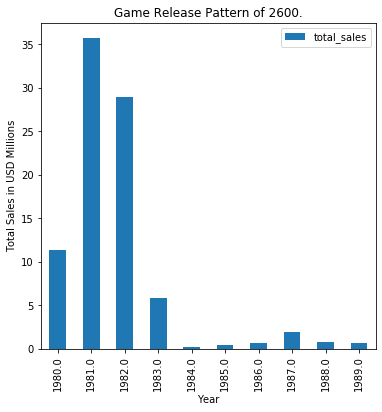

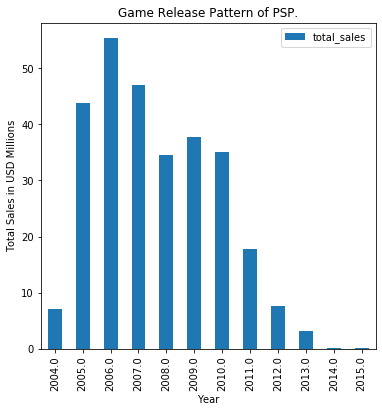

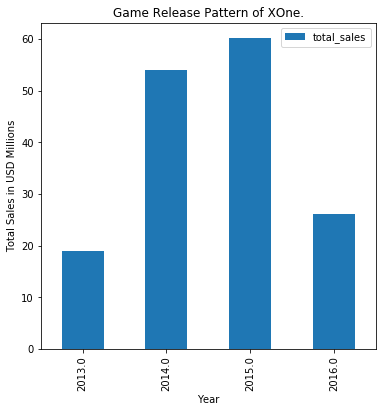

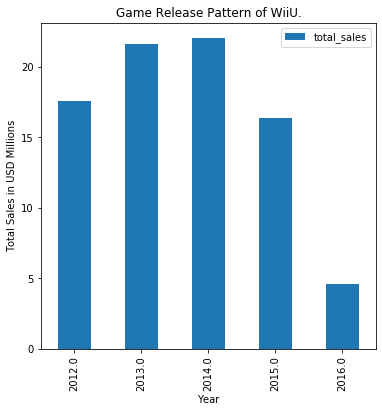

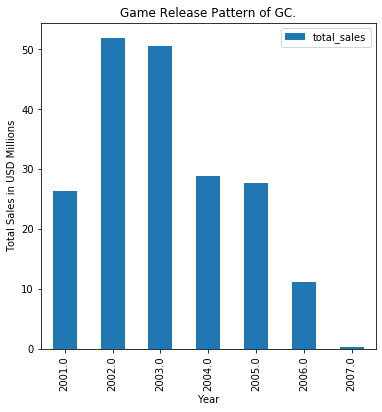

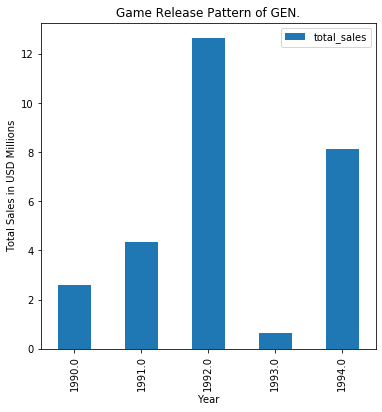

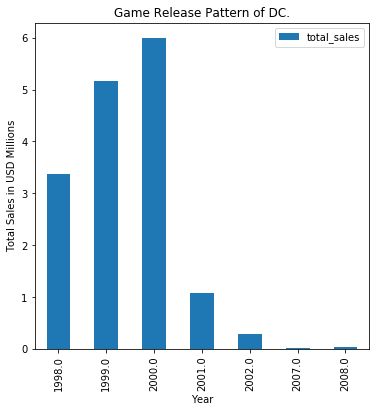

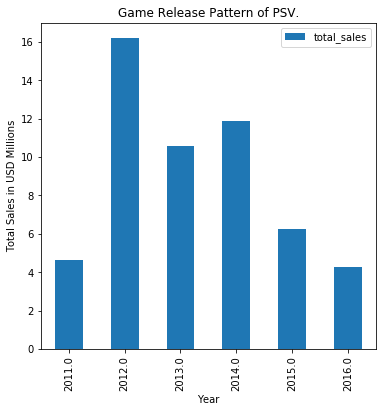

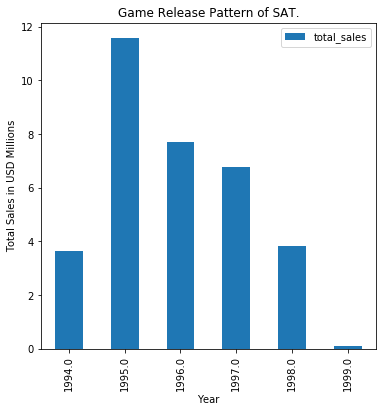

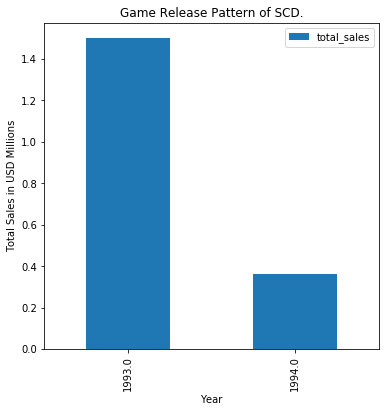

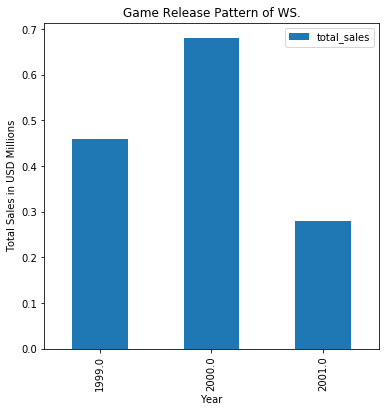

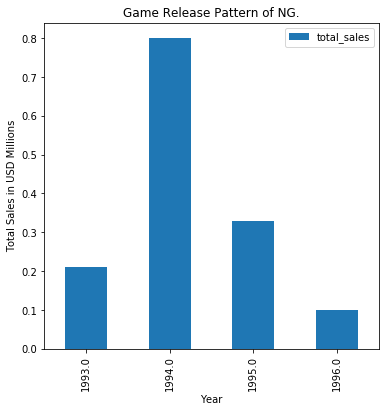

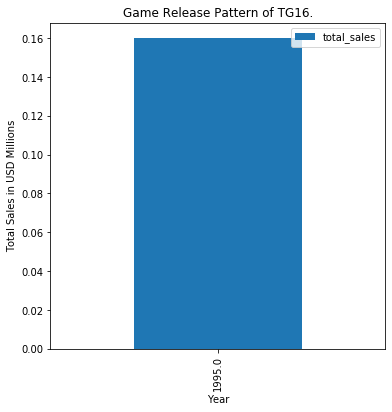

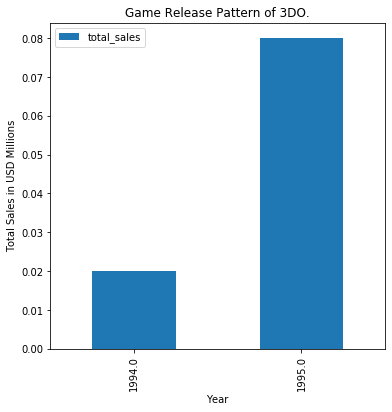

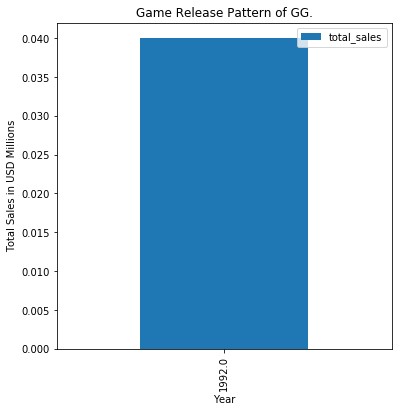

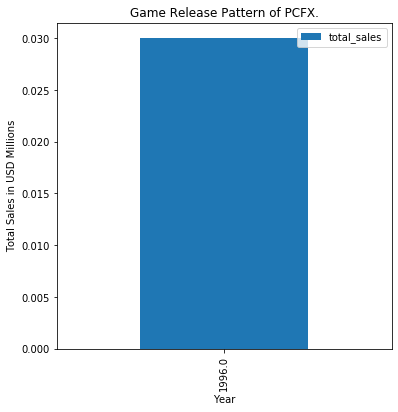

In [39]:
for platform in platforms:
    plot_platform(platform)

The patterns clearly depict the platform lifecycle. An initial rise is followed by a peak and then a decline as newer platforms become available. PC is the obvious exception. Let's find out the average and median lifetime of a console.

In [40]:
years_by_platform = games.groupby('platform')['year_of_release'].agg(['max','min'])
years_by_platform['lifespan'] = years_by_platform['max'] - years_by_platform['min']

In [41]:
years_by_platform

,max,min,lifespan
platform,,,
2600,1989.0,1980.0,9.0
3DO,1995.0,1994.0,1.0
3DS,2016.0,2011.0,5.0
DC,2008.0,1998.0,10.0
DS,2013.0,1985.0,28.0
GB,2001.0,1988.0,13.0
GBA,2007.0,2000.0,7.0
GC,2007.0,2001.0,6.0
GEN,1994.0,1990.0,4.0


We will drop PC as that will skew results without providing meaningful information. 

In [42]:
years_by_platform = years_by_platform.drop('PC')

In [43]:
years_by_platform.describe()

,max,min,lifespan
count,30.0000,30.000000,30.000000
mean,2004.9000,1998.066667,6.833333
std,9.2115,8.936301,5.583741
min,1989.0000,1980.000000,0.000000
25%,1996.0000,1993.000000,3.000000
50%,2005.0000,1997.000000,6.000000
75%,2015.7500,2004.750000,10.000000
max,2016.0000,2013.000000,28.000000


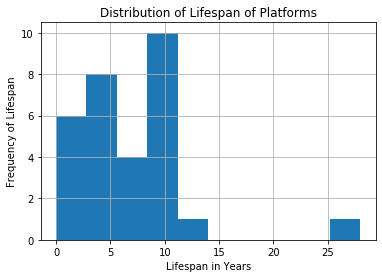

In [44]:
years_by_platform.hist(column = 'lifespan')
plt.title('Distribution of Lifespan of Platforms')
plt.xlabel('Lifespan in Years')
plt.ylabel('Frequency of Lifespan');

In [45]:
mean_lifespan = years_by_platform['lifespan'].mean()
std_lifespan  = years_by_platform['lifespan'].std()
n_dist = st.norm(mean_lifespan,std_lifespan)
x_axis = np.arange(0,25,1)

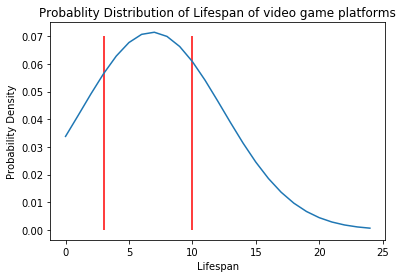

In [46]:
plt.plot(x_axis, n_dist.pdf(x_axis))
plt.vlines(x=[3,10], ymin = 0, ymax = 0.07, colors = 'red')
plt.title('Probablity Distribution of Lifespan of video game platforms')
plt.xlabel('Lifespan')
plt.ylabel('Probability Density');

**Let's talk about the observations**
1. The average lifespan of a console is ~ 7 years. 
2. The median lifespan is 6 years. We consider this a more accurate measure due to significant outlier presence.
3. The distribution of lifespan is right-skewed due to outliers. However, we see that the most consoles have a lifespan between 3-10 years.
4. We see a "ramp-up" period for sale of games. This period is usually 1-2 years. Peak sales periods can vary significantly across platforms.

### Data Slicing

When analysing recent trends, we must take data from at least 7 years ago. We will consider 10 years of data as this is likely to capture most relevant data. Let's slice accordingly.

In [47]:
games.groupby('platform')['year_of_release'].max()

platform
2600    1989.0
3DO     1995.0
3DS     2016.0
DC      2008.0
DS      2013.0
GB      2001.0
GBA     2007.0
GC      2007.0
GEN     1994.0
GG      1992.0
N64     2002.0
NES     1994.0
NG      1996.0
PC      2016.0
PCFX    1996.0
PS      2003.0
PS2     2011.0
PS3     2016.0
PS4     2016.0
PSP     2015.0
PSV     2016.0
SAT     1999.0
SCD     1994.0
SNES    1999.0
TG16    1995.0
WS      2001.0
Wii     2016.0
WiiU    2016.0
X360    2016.0
XB      2008.0
XOne    2016.0
Name: year_of_release, dtype: float64

Let's create a slice of all games where year of release is greater than 2006.

In [48]:
games_significant = games.query('year_of_release > 2013')

In [49]:
data_left = games_significant.shape[0] / games.shape[0] * 100 
print(f'We are left with {data_left:.2f}% data')

We are left with 10.27% data


This is fine as we want the data to be relevant to current trends.

### Platform Analysis

In [50]:
platforms_pivot = games_significant.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')

In [51]:
platforms_pivot

,total_sales
platform,
3DS,86.68
PC,27.05
PS3,68.18
PS4,288.15
PSP,0.36
PSV,22.40
Wii,5.07
WiiU,42.98
X360,48.22


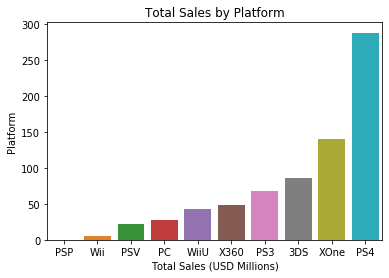

In [52]:
data = platforms_pivot.sort_values(by = 'total_sales')
sns.barplot(data = data,x = data.index, y = 'total_sales')
sns.set(rc = {'figure.figsize':(10,10)})
plt.title('Total Sales by Platform')
plt.xlabel('Total Sales (USD Millions)')
plt.ylabel('Platform');

We see a clear dominant trend for PS4, Xbox One and 3DS

In [53]:
platforms_by_year = games_significant.pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum')
platforms_by_year

total_sales
platform year_of_release             
3DS      2014.0                 43.76
         2015.0                 27.78
         2016.0                 15.14
PC       2014.0                 13.28
         2015.0                  8.52
         2016.0                  5.25
PS3      2014.0                 47.76
         2015.0                 16.82
         2016.0                  3.60
PS4      2014.0                100.00
         2015.0                118.90
         2016.0                 69.25
PSP      2014.0                  0.24
         2015.0                  0.12
PSV      2014.0                 11.90
         2015.0                  6.25
         2016.0                  4.25
Wii      2014.0                  3.75
         2015.0                  1.14
         2016.0                  0.18
WiiU     2014.0                 22.03
         2015.0                 16.35
         2016.0                  4.60
X360     2014.0                 34.74
         2015.0                 11.96
         2016.0                  1.52
XOne     2014.0                 54.07
         2015.0                 60.14
         2016.0                 26.15

In [54]:
platforms = games_significant['platform'].unique()

In [55]:
def plot_trends(platform):
    platforms_by_year.loc[platform].plot(kind = 'bar', figsize = (6,6))
    plt.title(f'Sales Trends for {platform}')
    plt.ylabel('Sales in USD Millions')
    plt.xlabel('Year');

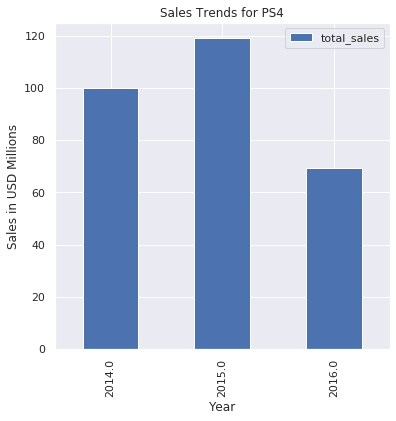

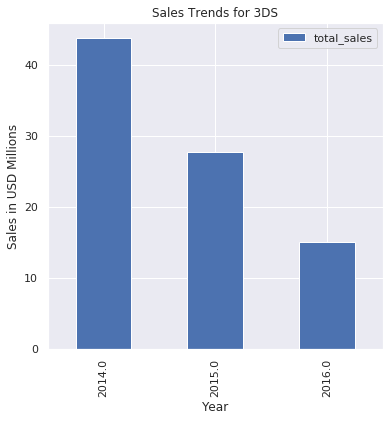

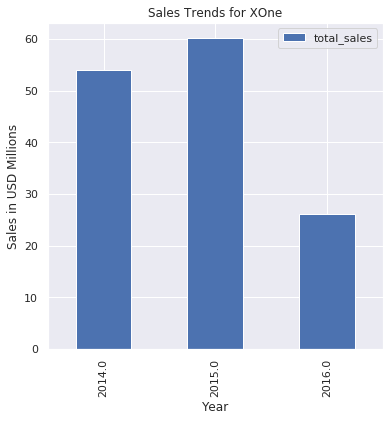

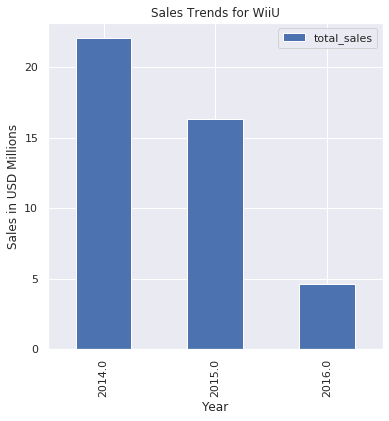

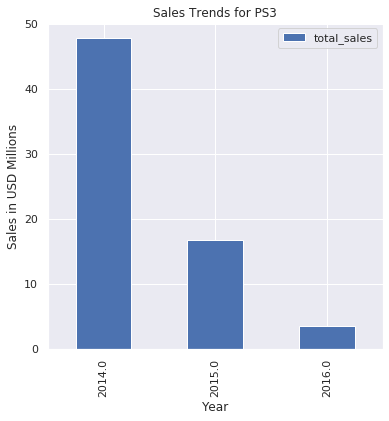

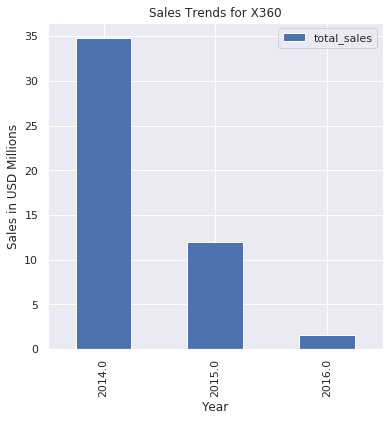

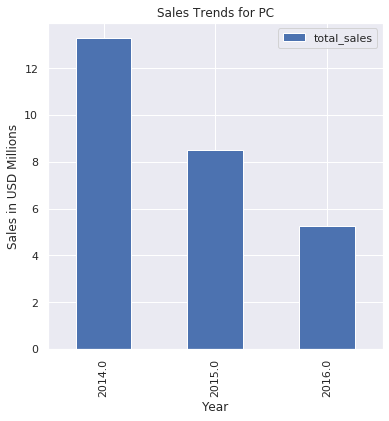

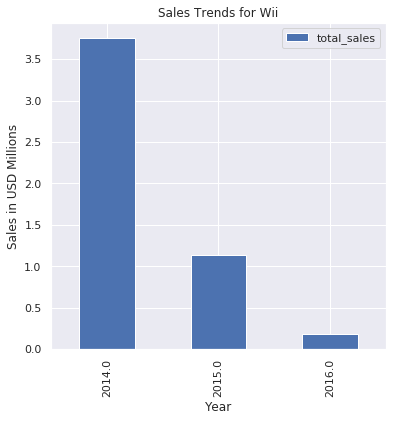

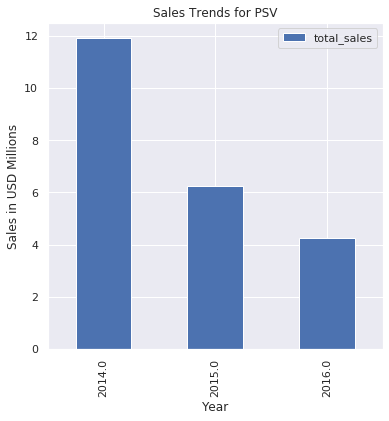

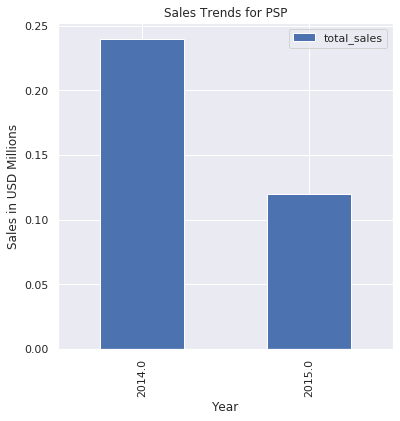

In [56]:
for platform in platforms:
    plot_trends(platform)

**Observations:**
1. It is quite evident that sales have declined for PS3, Wii and Xbox 360, leading up to 2016.
2. The trend is moving upwards for Xbox One and PS4.

We can conclude that the platforms most likely to be profitable are(in order):
1. PS4
2. Xbox One
3. 3DS - which shows strong but declining sales
4. PC - which shows consistent sales figures but has dropped off a peak

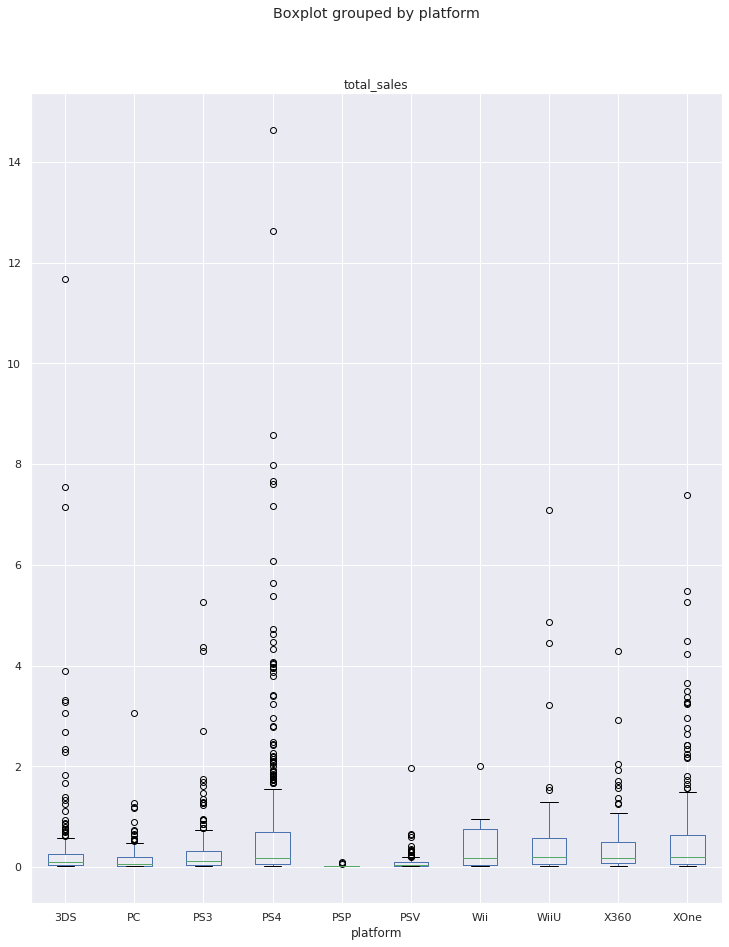

In [57]:
games_significant.boxplot(column = 'total_sales', by = 'platform', figsize = (12,15));

We notice that significant outliers exist for all platforms. The most significant outliers are for Wii, Xbox360 and PS3. It may be tempting to dismiss outliers but the video game industry frequently sees the release of games that outperform averages. Such games tend to have legacy value or are hotly anticipated. We can see that the median sale for games is quite similar across platforms but higher for established platforms like Xbox, PS and Wii. Let's dive further in to the values to understand this. 

In [58]:
sale_figures_platform = games_significant.pivot_table(index = 'platform', values = 'total_sales', aggfunc = ['mean','median','count'])

In [59]:
sale_figures_platform.sort_values(by = ('mean','total_sales'))

,mean,median,count
,total_sales,total_sales,total_sales
platform,,,
PSP,0.027692,0.020,13
PSV,0.075932,0.040,295
PC,0.179139,0.060,151
PS3,0.311324,0.110,219
3DS,0.408868,0.090,212
X360,0.434414,0.180,111
Wii,0.460909,0.180,11
WiiU,0.588767,0.190,73


We clearly see some leading platforms by median, mean and count. Adding to our observations, we see:
1. PS4 has the highest mean total sales
2. Xbox One has the highest median sales
3. WiiU has high mean and median sales.
4. 3DS lags in median sales. 

### Correlation of Reviews to Sales

Let's find out how sales are affected by `critic_score` for the most popular platform, PS4

In [60]:
ps4 = games_significant.query('platform == "PS4"')
ps4

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
92,Call of Duty: Advanced Warfare,PS4,2014.0,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
...,...,...,...,...,...,...,...,...,...,...,...,...
16500,Root Letter,PS4,2016.0,Adventure,0.00,0.00,0.01,0.00,69.0,7.5,M,0.01
16503,Shin Hayarigami 2,PS4,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16526,Dungeons 2,PS4,2016.0,Role-Playing,0.01,0.00,0.00,0.00,61.0,7.9,T,0.01
16530,Carmageddon: Max Damage,PS4,2016.0,Action,0.01,0.00,0.00,0.00,51.0,5.5,M,0.01


In [61]:
ps4['critic_score'].corr(ps4['total_sales'])

0.37694090382229234

We see a slight positive correlation between `critic_score` and `total_sales`. Is it accurate? Let's plot a scatter plot to see this in action.

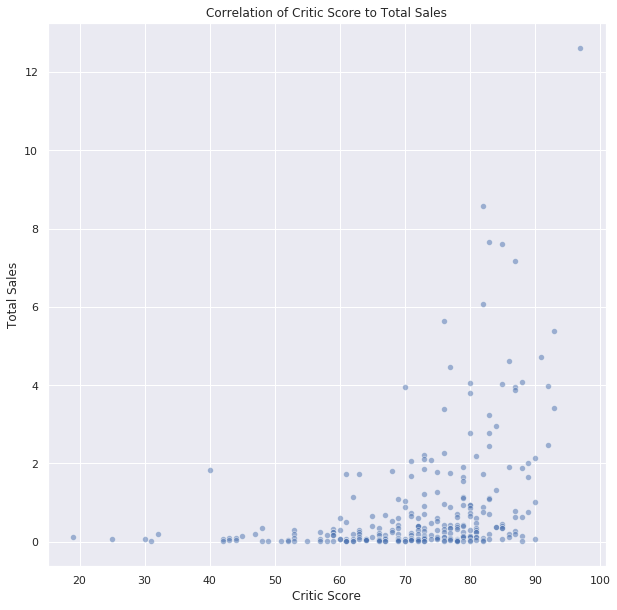

In [62]:
sns.scatterplot(data = ps4, x ='critic_score', y = 'total_sales', alpha = 0.5)
plt.title('Correlation of Critic Score to Total Sales')
plt.xlabel('Critic Score')
plt.ylabel('Total Sales');

The correlation is the visible. 

In [63]:
ps4_games = ps4['name'].unique()

In [64]:
ps4_games

array(['Call of Duty: Black Ops 3', 'Grand Theft Auto V', 'FIFA 16',
       'Star Wars Battlefront (2015)', 'Call of Duty: Advanced Warfare',
       'FIFA 17', 'Fallout 4', 'FIFA 15', 'Destiny',
       "Uncharted 4: A Thief's End", 'The Last of Us',
       'Uncharted: The Nathan Drake Collection',
       'Call of Duty: Infinite Warfare', 'Minecraft', 'Battlefield 1',
       'Watch Dogs', 'Far Cry 4', 'The Witcher 3: Wild Hunt',
       "Assassin's Creed: Unity", 'Batman: Arkham Knight', 'NBA 2K16',
       "Tom Clancy's The Division",
       'Metal Gear Solid V: The Phantom Pain',
       "Assassin's Creed Syndicate", 'Madden NFL 16',
       'Middle-Earth: Shadow of Mordor', 'inFAMOUS: Second Son',
       'Mortal Kombat X', 'Bloodborne', 'NBA 2K15',
       'Need for Speed (2015)', 'Far Cry: Primal',
       "Tom Clancy's Rainbow Six: Siege", 'Madden NFL 15', 'Overwatch',
       'Battlefield: Hardline', 'Dying Light', 'DriveClub',
       'Dragon Age: Inquisition', 'Destiny: The Taken King',

In [65]:
games_on_ps4 = games_significant.query('name.isin(@ps4_games)')

In [66]:
games_on_ps4

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
92,Call of Duty: Advanced Warfare,PS4,2014.0,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
...,...,...,...,...,...,...,...,...,...,...,...,...
16672,Metal Gear Solid V: The Definitive Experience,XOne,2016.0,Action,0.01,0.00,0.00,0.00,78.0,NaN,M,0.01
16691,Dynasty Warriors: Eiketsuden,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16692,Metal Gear Solid V: Ground Zeroes,PC,2014.0,Action,0.00,0.01,0.00,0.00,80.0,7.6,M,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


In [67]:
games_also_on_ps4 = games_on_ps4.query('platform != "PS4"')

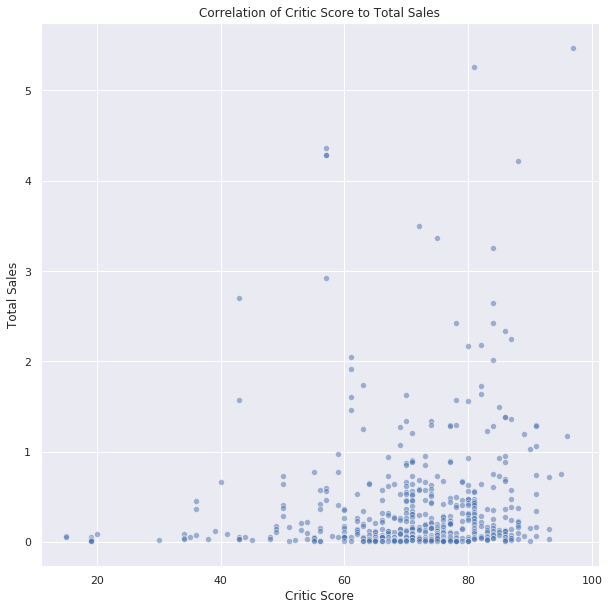

In [68]:
sns.scatterplot(data = games_also_on_ps4, x ='critic_score', y = 'total_sales', alpha = 0.5)
plt.title('Correlation of Critic Score to Total Sales')
plt.xlabel('Critic Score')
plt.ylabel('Total Sales');

In [69]:
games_also_on_ps4['critic_score'].corr(games_also_on_ps4['total_sales'])

0.12038716808354115

We see a lower correlation in this case. However, the general trend is still observable

### Trends by Genre

Let's observe some trends by genre.

In [70]:
genres_main = games_significant.pivot_table(index = 'genre', values = 'total_sales', aggfunc = ['mean','median','sum','count']).sort_values(by = ('sum','total_sales'))
genres_main

,mean,median,sum,count
,total_sales,total_sales,total_sales,total_sales
genre,,,,
Puzzle,0.157857,0.045,2.21,14
Strategy,0.107027,0.060,3.96,37
Simulation,0.298409,0.100,13.13,44
Adventure,0.094865,0.030,17.55,185
Platform,0.476053,0.140,18.09,38
Racing,0.398841,0.090,27.52,69
Fighting,0.470333,0.125,28.22,60
Misc,0.332301,0.090,37.55,113


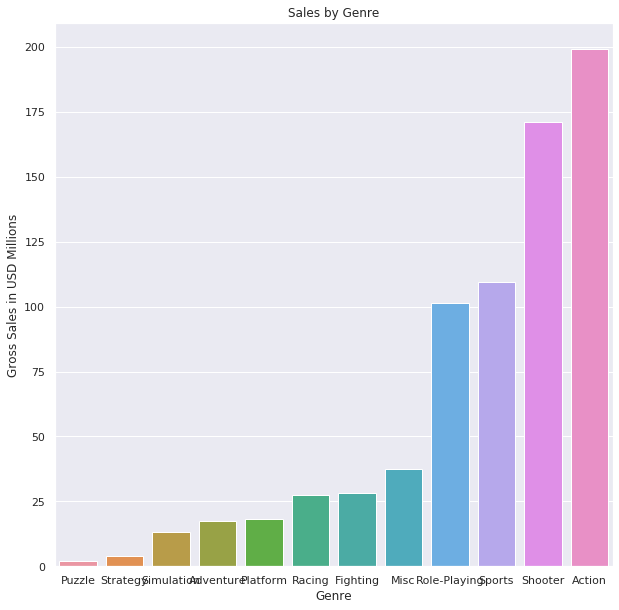

In [71]:
sns.barplot(data = genres_main['sum'], x = genres_main.index, y = 'total_sales')
sns.set(rc = {'figure.figsize':(14,8)})
plt.title('Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Gross Sales in USD Millions');

**Observations**:
1. Action genre has the highest total sale but also the highest total count of games released.
2. Platform genre earns the highest on an average, however, Shooters have the highest median sales.
3. Puzzle games perform the worst in terms of total sales. 
4. Adventure games have the lowest median and meanm indicating that they are less likely to earn high revenues

## User Profiles

### Profiles by Region

Let's understand user profiles by region (NA, EU, Japan)
First, we consider the top 5 platforms. We will consider the following based on a mix of total sales and trend of sales:
1. PS4
2. Xbox One
3. PS3
4. Xbox360
5. 3DS

In [72]:
top_5_platforms = ['PS3', 'X360','PS4','XOne','3DS']

In [73]:
top_5 = games_significant.query('platform.isin(@top_5_platforms)')

In [74]:
top_5

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014.0,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
77,FIFA 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16672,Metal Gear Solid V: The Definitive Experience,XOne,2016.0,Action,0.01,0.00,0.00,0.00,78.0,NaN,M,0.01
16674,Tsukigime Ranko's Longest Day,PS3,2014.0,Action,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16677,Aikatsu Stars! My Special Appeal,3DS,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16691,Dynasty Warriors: Eiketsuden,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


In [75]:
top_5_pivot = top_5.pivot_table(index = 'platform', values = ['na_sales','eu_sales','jp_sales'], 
                  aggfunc = ['sum','median','mean'])

In [76]:
top_5_pivot

sum                     median                        mean  \
         eu_sales jp_sales na_sales eu_sales jp_sales na_sales  eu_sales   
platform                                                                   
3DS         16.12    44.24    22.64     0.00    0.055     0.00  0.076038   
PS3         25.54    11.22    22.05     0.01    0.020     0.02  0.116621   
PS4        130.04    15.02    98.61     0.07    0.015     0.05  0.345851   
X360        15.49     0.08    28.30     0.05    0.000     0.10  0.139550   
XOne        46.25     0.32    81.27     0.07    0.000     0.10  0.202851   

                              
          jp_sales  na_sales  
platform                      
3DS       0.208679  0.106792  
PS3       0.051233  0.100685  
PS4       0.039947  0.262261  
X360      0.000721  0.254955  
XOne      0.001404  0.356447

In [77]:
(top_5_pivot['sum'] / top_5_pivot['sum'].sum() * 100)

,eu_sales,jp_sales,na_sales
platform,,,
3DS,6.905415,62.415350,8.953217
PS3,10.940713,15.829571,8.719896
PS4,55.705963,21.190745,38.996322
X360,6.635538,0.112867,11.191521
XOne,19.812371,0.451467,32.139044


**Observations**:
1. Users tend to prefer the 3DS platform in Japan more than NA or EU with more than 60% share
2. PS4 games command the strongest market share in EU and NA.
3. Xbox One is strongly preferred in NA but has a very low share in Japan.
4. PS3 continues to command a large share in Japan in spite of the newer PS4 available.
5. 3DS has small shares in EU and NA.

### Profiles by Genre

Let's find out the genre profiles and their variations by each region. 

In [78]:
genres = games_significant.pivot_table(index = ['genre'], values = ['na_sales','eu_sales','jp_sales'],
                              aggfunc = ['sum','median','mean'])

In [79]:
genres

sum                     median                        mean  \
             eu_sales jp_sales na_sales eu_sales jp_sales na_sales  eu_sales   
genre                                                                          
Action          74.68    29.58    72.53    0.020     0.01    0.010  0.120646   
Adventure        6.49     3.60     5.64    0.000     0.01    0.000  0.035081   
Fighting         6.69     6.37    12.43    0.020     0.03    0.040  0.111500   
Misc            12.86     5.61    15.05    0.010     0.01    0.010  0.113805   
Platform         6.80     2.69     6.79    0.055     0.00    0.075  0.178947   
Puzzle           0.52     0.93     0.65    0.000     0.03    0.000  0.037143   
Racing          14.13     1.76     8.74    0.050     0.00    0.030  0.204783   
Role-Playing    28.17    31.16    33.47    0.010     0.05    0.020  0.127466   
Shooter         65.52     4.87    79.02    0.220     0.00    0.220  0.511875   
Simulation       7.30     2.31     2.63    0.030     0.00    0.000  0.165909   
Sports          45.73     3.26    46.13    0.050     0.00    0.070  0.284037   
Strategy         1.79     0.95     0.98    0.010     0.00    0.000  0.048378   

                                  
              jp_sales  na_sales  
genre                             
Action        0.047787  0.117173  
Adventure     0.019459  0.030486  
Fighting      0.106167  0.207167  
Misc          0.049646  0.133186  
Platform      0.070789  0.178684  
Puzzle        0.066429  0.046429  
Racing        0.025507  0.126667  
Role-Playing  0.140995  0.151448  
Shooter       0.038047  0.617344  
Simulation    0.052500  0.059773  
Sports        0.020248  0.286522  
Strategy      0.025676  0.026486

**Observations:**
1. We see that the popularity of genres varies by region. 
2. The most popular genre in EU and NA by sheer volume is Action.
3. The most popular genre in Japan is Role-Playing, closely followed by Action.

Top Genres by Region:

**EU**:

In [80]:
eu_top_genres = genres['sum']['eu_sales'].sort_values(ascending = False)
eu_top_genres.head()

genre
Action          74.68
Shooter         65.52
Sports          45.73
Role-Playing    28.17
Racing          14.13
Name: eu_sales, dtype: float64

**NA**:

In [81]:
na_top_genres = genres['sum']['na_sales'].sort_values(ascending = False)
na_top_genres.head()

genre
Shooter         79.02
Action          72.53
Sports          46.13
Role-Playing    33.47
Misc            15.05
Name: na_sales, dtype: float64

**Japan**

In [82]:
jp_top_genres = genres['sum']['jp_sales'].sort_values(ascending = False)
jp_top_genres.head()

genre
Role-Playing    31.16
Action          29.58
Fighting         6.37
Misc             5.61
Shooter          4.87
Name: jp_sales, dtype: float64

### Effect of Ratings on Sales

Let's find out if ESRB Ratings affect sales across regions. 

In [83]:
ratings = games_significant.pivot_table(index = 'rating',values = ['na_sales','eu_sales','jp_sales'],
                              aggfunc = ['sum','median','mean','count'])
ratings

sum                     median                        mean  \
       eu_sales jp_sales na_sales eu_sales jp_sales na_sales  eu_sales   
rating                                                                   
E         58.32     8.98    50.81     0.05     0.00     0.04  0.254672   
E10+      27.51     4.77    34.56     0.09     0.00     0.10  0.141077   
M        100.99     8.55   103.44     0.11     0.00     0.10  0.330033   
T         35.33    16.28    40.28     0.03     0.01     0.03  0.116987   

                              count                    
        jp_sales  na_sales eu_sales jp_sales na_sales  
rating                                                 
E       0.039214  0.221878      229      229      229  
E10+    0.024462  0.177231      195      195      195  
M       0.027941  0.338039      306      306      306  
T       0.053907  0.133377      302      302      302

**Observations**:
1. By median and mean metrics, we see that games with rating M tend to generate more revenue for NA and EU, indicating the appetite for games for a mature audience.
2. In Japan, games rated E and T generate higher revenues, indicating a preference for games in Everyone and Teen ratings.
3. The highest median and mean revenue regardless of rating is generated in North America. 
4. By total sales, games rated E generate the most revenue due to higher volumes. 

## Testing Hypotheses

### Average user ratings of the Xbox One and PC platforms are the same.

Our Hypotheses are as follows:
* Ho - There is no significant difference between the average user ratings for Xbox One and PC games.
* H1 - There exists a significant difference between the average user ratings for Xbox One and PC games. 

Let's test.

In [84]:
#Define a low alpha
alpha = 0.01

In [85]:
xbox_one_ratings = games_significant.query('platform == "XOne"')['user_score']
xbox_one_ratings

99       NaN
165      7.9
179      5.4
242      6.4
270      6.2
        ... 
16630    8.2
16643    6.6
16645    7.7
16660    6.7
16672    NaN
Name: user_score, Length: 228, dtype: float64

In [86]:
pc_ratings = games_significant.query('platform == "PC"')['user_score']
pc_ratings

458      3.9
1530     5.4
1677     NaN
1730     7.9
2303     5.7
        ... 
16509    7.9
16518    1.4
16617    NaN
16631    NaN
16692    7.6
Name: user_score, Length: 151, dtype: float64

The datasets are not equally sized. We will use an independent t-test with differences in the means to measure the p-values. 

In [87]:
result = st.ttest_ind(xbox_one_ratings,pc_ratings, equal_var = False, nan_policy = 'omit')
print(f'P-Value is {result.pvalue:.2f}.')
if result.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print('We cannot reject the null hypothesis.')

P-Value is 0.02.
We cannot reject the null hypothesis.


### Average user ratings for the Action and Sports genres are different

Our Hypotheses are as follows:
* Ho - There is no significant difference between the average user ratings for Action and Sports Genre.
* H1 - There exists a significant difference between the average user ratings for Action and Sports Genre. 

In [88]:
action_ratings = games_significant.query('genre == "Action"')['user_score']
action_ratings

42       8.3
165      7.9
225      9.5
231      8.1
295      6.3
        ... 
16680    NaN
16691    NaN
16692    7.6
16699    NaN
16710    NaN
Name: user_score, Length: 619, dtype: float64

In [89]:
action_ratings.isna().sum()

277

In [90]:
action_ratings.describe()

count    342.000000
mean       6.874561
std        1.374387
min        2.000000
25%        6.300000
50%        7.100000
75%        7.800000
max        9.500000
Name: user_score, dtype: float64

In [91]:
sports_ratings = games_significant.query('genre == "Sports"')['user_score']
sports_ratings

77       4.3
94       5.0
143      5.7
264      4.5
314      6.7
        ... 
16241    7.8
16428    NaN
16518    1.4
16638    5.3
16643    6.6
Name: user_score, Length: 161, dtype: float64

In [92]:
sports_ratings.describe()

count    141.000000
mean       5.195035
std        1.901853
min        0.200000
25%        3.800000
50%        5.500000
75%        6.700000
max        8.800000
Name: user_score, dtype: float64

In [93]:
sports_ratings.isna().sum()

20

Once again, the datasets have differing sizes. 

In [94]:
result = st.ttest_ind(action_ratings,sports_ratings,equal_var = False, nan_policy = 'omit')
print(f'P-Value is {result.pvalue:.2f}.')
if result.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print('We cannot reject the null hypothesis.')

P-Value is 0.00.
We reject the null hypothesis


**Conclusions of the Hypothesis Testing:**
1. There is no significant difference between the user ratings for Xbox One and PC.
2. There is a significant difference between user ratings for Action and Sports genres. 

## Conclusion

### The Objectives:

The objectives of the study were to analyze data for video games across genres and platforms in order to inform decisions about the best way to run advertising campaigns for an online video game store. 

### The Data: 

The data contains the following columns: 
1. `Name` - The title of the game
2. `Platform` - The platform for which the game was released
3. `Year of Release`
4. `Genre` - Genre of the game
5. `NA_sales` - North America Sales(in millions)
6. `EU_sales` - EU Sales (in millions)
7. `JP_sales` - Japan Sales(in millions)
8. `Other_sales` - Sales in other countries(in millions)
9. `Critic_Score` - A score out of 100
10. `User_Score` - A score out of 10
11. `Rating` - ESRB Rating

#### Clean Up:

During the cleaning of data we: 
1. Renamed the columns for easier handling
2. Handled nan-quivalent values in the `user_score` column and corrected the data type.
3. Dealt with missing values by closely approximating `critic_score` and `user_score` with each other due to a strong correlation. We also filled values for the `rating` column by sourcing data from other platforms for the same game. 
4. Added a `total_sales` column which summed sales from all regions.

### Platform Analysis:

#### Significant Years:

* We analyzed the trend for platforms to become obsolete and found that platforms remain relevant and generate sales for an average of 7 years. We assumed a safe limit of 3-4 years for games to remain relevant.


* Accordingly, we created a new dataset with only significant values, i.e. games released after 2013. We were left with ~10% data, however, we can sufficiently trust this data to inform future decisions.

#### Platform Comparison:

* We compared total sales and trends by platform observing high total sales for PS4, Xbox One, 3DS and PS3 but declining trends for PS3, Xbox360, 3DS and Wii .We observed increasing trends for Xbox One and PS4 with stagnant sales for PC. 


* We decided to choose PS4, Xbox One, 3DS and PC for deeper analysis as these displayed promising possibilities for future sales. 


* The distribution of total sales shows that significant outliers exist. This is not surprising as some larger games tend to command huge sales. We see that median and average sales for games tend to be similar for most platforms. Established platforms such as PS3/4, Xbox and Wii command higher median sales for games. It makes sense to advertise for these. 


* Further we saw that:

    1. PS4 has the highest mean total sales
    2. Xbox One has the highest median sales
    3. WiiU has high mean and median sales.
    4. 3DS lags in median sales. 
    
#### Reviews and Sales

We studied the correlation of sales with critics' scores for games on PS4, the top selling platform. 

We found that: 

1. There's a positive correlation(0.37) between critics' score and total sales.

2. For the same games, there is a smaller correlation(0.12) for other platforms. 

### Trends 

#### Trends by Genre

1. Action genre has the highest total sale but also the highest total count of games released.
2. Platform genre earns the highest on an average, however, Shooters have the highest median sales.
3. Puzzle games perform the worst in terms of total sales. 
4. Adventure games have the lowest median and meanm indicating that they are less likely to earn high revenues

### User Profiles 

#### Profiles by Region

We chose 5 top platforms: 
1. PS4
2. Xbox One
3. PS3
4. Xbox360
5. 3DS

We observed: 

1. Users tend to prefer the 3DS platform in Japan more than NA or EU with more than 60% share
2. PS4 games command the strongest market share in EU and NA.
3. Xbox One is strongly preferred in NA but has a very low share in Japan.
4. PS3 continues to command a large share in Japan in spite of the newer PS4 available.
5. 3DS has small shares in EU and NA.

#### Profiles by Genre:

1. We see that the popularity of genres varies by region. 
2. The most popular genre in EU and NA by sheer volume is Action.
3. The most popular genre in Japan is Role-Playing, closely followed by Action.

We also pointed out the top 5 genres for each region. 

#### Sales by Ratings: 

1. By median and mean metrics, we see that games with rating M tend to generate more revenue for NA and EU, indicating the appetite for games for a mature audience.
2. In Japan, games rated E and T generate higher revenues, indicating a preference for games in Everyone and Teen ratings.
3. The highest median and mean revenue regardless of rating is generated in North America. 
4. By total sales, games rated E generate the most revenue due to higher volumes.

### Testing Hypotheses

#### Average user ratings of the Xbox One and PC platforms are the same:

Our Hypotheses were as follows:

* Ho - There is no significant difference between the average user ratings for Xbox One and PC games.
* H1 - There exists a significant difference between the average user ratings for Xbox One and PC games. 

With a p-value of 0.02, higher than our chosen alpha, we cannot reject Ho

#### Average user ratings for the Action and Sports genres are different:

* Ho - There is no significant difference between the average user ratings for Action and Sports Genre.
* H1 - There exists a significant difference between the average user ratings for Action and Sports Genre. 

With a p-value of 0.00, we reject Ho and accept H1. 

**Final Conclusion**:
1. We can recommend that PS4, Xbox One and 3DS are the likeliest to be profitable. 
2. We can recommend Action or Shooter genre for NA and EU markets.
3. We recommend Role-Playing and Action for Japan. 
4. We recommend games with M or E rating for NA and EU markets. 
5. We recommend games with E or T rating for Japan.